<a href="https://colab.research.google.com/github/nemo0001/Python/blob/master/cardio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Uploading Dataset

In [384]:
#getting the data from PC

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving cardio_train.csv to cardio_train (9).csv
User uploaded file "cardio_train.csv" with length 2941524 bytes


In [ ]:
#After getting abnormal logistic regression values with huge diff. before and after Hyper-Parameter tuning.
#We resorted to removal of irrelavant variable via Corr Matrix, Important Features of Random forest
#We removed normalization since it was creating abnormal results

###Importing Libraries

In [385]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop,Nadam,Adadelta,Adam
from tensorflow.keras.layers import BatchNormalization,LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import seaborn as sns
import scipy.stats as stats
import sklearn
import os
from sklearn.preprocessing import normalize

#Importing Models
import sklearn.linear_model as lm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

#Optimization and Evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix,classification_report
%matplotlib inline
import matplotlib.pyplot as plt


In [386]:
data_raw=pd.read_csv("cardio_train.csv",sep=";")
data_raw.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [387]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


###Preliminary Data Processing

In [388]:
data_raw.drop("id",axis=1,inplace=True)

In [389]:
#handling duplicate values
print("There are {} duplicate values in data frame".format(data_raw.duplicated().sum()))

There are 24 duplicate values in data frame


In [390]:
#We can drop the duplicates because they have no effect on training of model.
#Firstly let us look at the duplicated rows.
duplicated = data_raw[data_raw.duplicated(keep=False)]
duplicated = duplicated.sort_values(by=['age', "gender", "height"], ascending= False) 
#sorted the values to see duplication clearly

duplicated.head(2) # Shows us just 1 duplication of 24

#duplicated() method helps in analyzing duplicate values only. 
#It returns a boolean series which is True only for Unique elements.

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
2677,22077,1,175,69.0,120,80,1,1,0,0,1,1
45748,22077,1,175,69.0,120,80,1,1,0,0,1,1


In [391]:
data_raw.drop_duplicates(inplace=True)
#Return DataFrame with duplicate rows removed, optionally only considering certain columns.
#keep : {‘first’, ‘last’, False}, default ‘first’

print("There are {} duplicated values in data frame".format(data_raw.duplicated().sum()))

There are 0 duplicated values in data frame


In [392]:
print("There are {} missing values in data frame".format(data_raw.isnull().sum().sum()))

There are 0 missing values in data frame


###VISUALIZATION

In [393]:
#Detecting Outliers 
#Detecting outlier and handling them can increase our accuracy score.
x = data_raw.copy(deep=True)
x.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,1.349648,164.359152,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771
std,2467.374620,0.476862,8.211218,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [394]:
#Columns of "age", "height", "weight", "ap_hi", "ap_lo" may have outlier.
#In order to compare them on same scale we need to standardize firstly.
#My Standard Scalar Function
s_list = ["age", "height", "weight", "ap_hi", "ap_lo"]
def standartization(x):
    x_std = x.copy(deep=True)
    for column in s_list:
        x_std[column] = (x_std[column]-x_std[column].mean())/x_std[column].std()
    return x_std 
x_std=standartization(x)
x_std.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,-0.436071,2,0.443399,-0.847978,-0.122181,-0.088254,1,1,0,0,1,0
1,0.307635,1,-1.018016,0.749554,0.072577,-0.035205,3,1,0,0,1,1
2,-0.248017,1,0.078045,-0.709062,0.007658,-0.141303,3,1,0,0,0,1
3,-0.748143,2,0.565184,0.541180,0.137496,0.017844,1,1,0,0,1,1
4,-0.808532,1,-1.018016,-1.264725,-0.187100,-0.194352,1,1,0,0,0,0


In [395]:
#In order to use the multi box graph plot we need to melt out data.
x_melted = pd.melt(frame=x_std, id_vars="cardio", value_vars=s_list, var_name="features", value_name="value", col_level=None)
x_melted

#melt() function is useful to massage a DataFrame into a format where one or more columns are identifier variables, while all other columns, 
#considered measured variables, are unpivoted to the row axis, leaving just two non-identifier columns, variable and value.

,cardio,features,value
0,0,age,-0.436071
1,1,age,0.307635
2,1,age,-0.248017
3,1,age,-0.748143
4,0,age,-0.808532
...,...,...,...
349875,0,ap_lo,-0.088254
349876,1,ap_lo,-0.035205
349877,1,ap_lo,-0.035205
349878,1,ap_lo,-0.088254


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

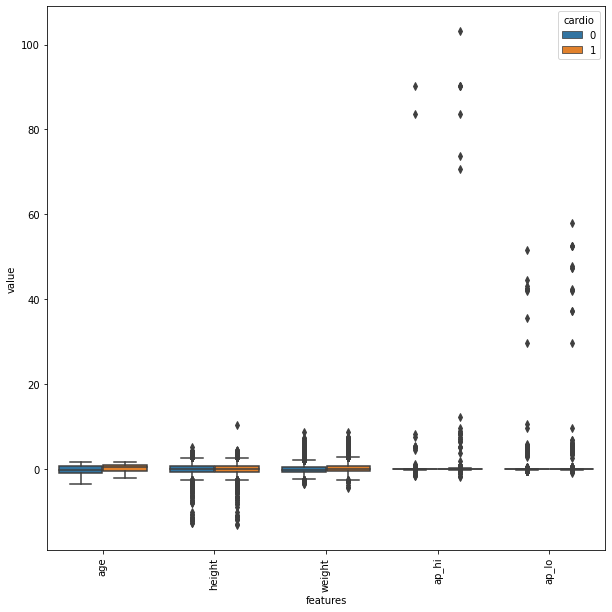

In [396]:
plt.figure(figsize=(10,10))
sns.boxplot(x="features", y="value", hue="cardio", data=x_melted)
plt.xticks(rotation=90)

###Outlier Detection

In [397]:
#There are some outliers in the dataset, but as seen above there is an unusual outlier in ap_hi and ap_lo features.
#Let us calculate the low bound and hi bound of ap_lo and ap_hi features
ap_list = ["ap_hi", "ap_lo","height","weight"]
boundary = pd.DataFrame(index=["lower_bound","upper_bound"]) # We created an empty dataframe
for each in ap_list:
    Q1 = x[each].quantile(0.25)
    Q3 = x[each].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1- 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    boundary[each] = [lower_bound, upper_bound ]
boundary

,ap_hi,ap_lo,height,weight
lower_bound,90.0,65.0,142.5,39.5
upper_bound,170.0,105.0,186.5,107.5


In [398]:
#We can select the index of outlier data by using boundaries we calculated.
ap_hi_filter = (x["ap_hi"] > boundary["ap_hi"][1])
ap_lo_filter = (x["ap_lo"] > boundary["ap_lo"][1])                                                           
outlier_filter = (ap_hi_filter | ap_lo_filter)
x_outliers = x[outlier_filter]
x_outliers["cardio"].value_counts()

1    2025
0     388
Name: cardio, dtype: int64

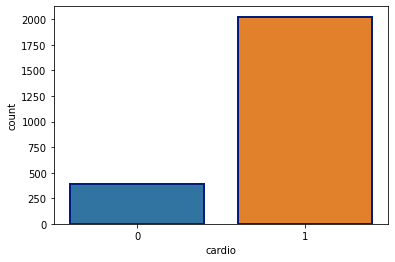

In [399]:
#And I have dropped some of data because we have sufficent data (70000) otherwise I would try to handle them by assigning new values.
sns.countplot(x='cardio',data=x_outliers,linewidth=2,edgecolor=sns.color_palette("dark", 1))

In [400]:
#A study published by doctors in NCBI NLM recorded a maximum blood pressure of 370/360 mm Hg. This study was performed by recording blood pressure in 10 male athletes through radial artery catheterization.
#Thus we can drop the ap_hi outlier values over 250 and ap_lo outlier values over 200, without fear of missing data.
out_filter_bp = ((x["ap_hi"]>250) | (x["ap_lo"]>200) )
print("There are {} outliers".format(x[out_filter_bp]["cardio"].count()))

#We remove lower and higher outliers for height and weight
ht_filter = (x["height"] > boundary["height"][1])
ht_filter_l = (x["height"] < boundary["height"][0])
wt_filter = (x["weight"] > boundary["weight"][1])
wt_filter_l = (x["weight"] < boundary["weight"][0])                                                           
outlier_filter_hw = (ht_filter | wt_filter|ht_filter_l|wt_filter_l)
x_outliers_hw = x[outlier_filter_hw]
x_outliers_hw["cardio"].value_counts()

out_filter_h = ((x["height"] > boundary["height"][1]) | (x["height"] < boundary["height"][0]))
out_filter_w = ((x["weight"] > boundary["weight"][1]) | (x["weight"] < boundary["weight"][0]))
print("There are {} outliers".format(x[out_filter_h]["cardio"].count()))
print("There are {} outliers".format(x[out_filter_w]["cardio"].count()))


There are 993 outliers
There are 519 outliers
There are 1819 outliers


In [401]:
x = x[~out_filter_bp]
x=x[~out_filter_h]
x=x[~out_filter_w]

#Higher diastolic than systolic blood pressure is impossible, too. So let's remove these.
x.drop(x[x["ap_lo"] > x["ap_hi"]].index, inplace=True)
x.drop(x[x["ap_lo"] <= 30].index, inplace=True)
x.drop(x[x["ap_hi"] <= 40].index, inplace=True)
x.drop(x[x["ap_lo"] >= 200].index, inplace=True)
x.drop(x[x["ap_hi"] >= 250].index, inplace=True)

x.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(66459, 12)

###Feature Selection

In [402]:
#Calculating BMI
def bmi_calc(w, h):
    return w/(h**2)
x["bmi"] = x["weight"]/ (x["height"]/100)**2

#Calculating Diff between systolic and diastolic :pulse pressure
x["BP_diff"]=x["ap_hi"]-x["ap_lo"]
x.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,BP_diff
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,30
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,50
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,60
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,50
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,40


In [403]:
x["gender"] = x["gender"] % 2

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

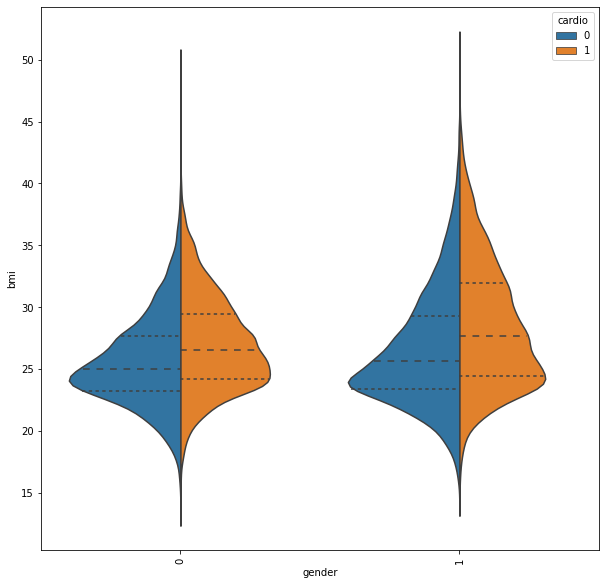

In [404]:
from sklearn.preprocessing import StandardScaler
x_std = standartization(x)

data = pd.melt(x_std,id_vars="cardio",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="gender", y="bmi", hue="cardio", data=x,split=True, inner="quart")
plt.xticks(rotation=90)
#If we interpret the violin plot, the median and quartiles of bmi distribution of patients is slightly higher than non-patients.

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,BP_diff
age,1.000000,0.021335,-0.085890,0.068481,0.213281,0.160724,0.157028,0.098836,-0.044958,-0.027551,-0.011062,0.243087,0.118476,0.174298
gender,0.021335,1.000000,-0.519479,-0.162291,-0.061069,-0.065718,0.038693,0.022920,-0.339302,-0.170253,-0.007178,-0.004527,0.126462,-0.033916
height,-0.085890,-0.519479,1.000000,0.310426,0.009114,0.027818,-0.064388,-0.026080,0.193968,0.094535,-0.007460,-0.019020,-0.237789,-0.009559
weight,0.068481,-0.162291,0.310426,1.000000,0.255413,0.242734,0.130159,0.091228,0.063305,0.064226,-0.015015,0.175799,0.845538,0.167928
ap_hi,0.213281,-0.061069,0.009114,0.255413,1.000000,0.733157,0.193048,0.087781,0.025061,0.032222,0.000865,0.428567,0.255614,0.833799
ap_lo,0.160724,-0.065718,0.027818,0.242734,0.733157,1.000000,0.158147,0.069367,0.023605,0.034183,0.000738,0.338930,0.232288,0.235866
cholesterol,0.157028,0.038693,-0.064388,0.130159,0.193048,0.158147,1.000000,0.449185,0.006794,0.033367,0.009425,0.220301,0.168062,0.147476
gluc,0.098836,0.022920,-0.026080,0.091228,0.087781,0.069367,0.449185,1.000000,-0.009974,0.006446,-0.007052,0.088919,0.107065,0.069125
smoke,-0.044958,-0.339302,0.193968,0.063305,0.025061,0.023605,0.006794,-0.009974,1.000000,0.341654,0.028331,-0.019440,-0.043833,0.016650
alco,-0.027551,-0.170253,0.094535,0.064226,0.032222,0.034183,0.033367,0.006446,0.341654,1.000000,0.026696,-0.010534,0.012037,0.018295


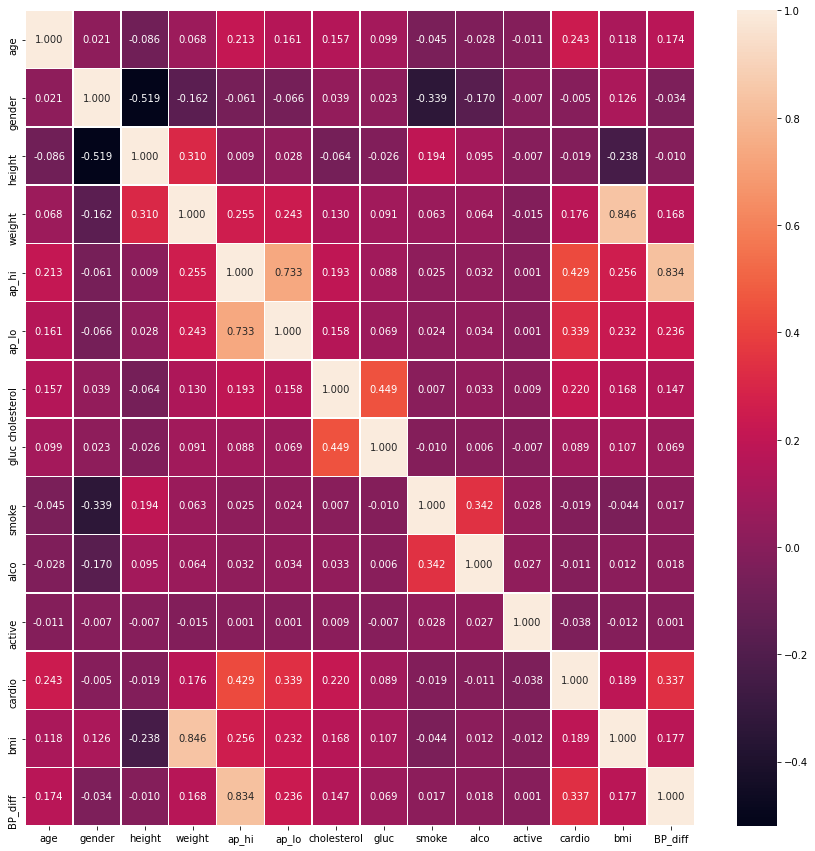

In [405]:

corr = x.corr()
f, ax = plt.subplots(figsize = (15,15))
sns.heatmap(corr, annot=True, fmt=".3f", linewidths=0.5, ax=ax)
corr

#We can see from correlation map easily; cholesterol, blood pressure (ap_hi and ap_low both) and age have a powerful relationship with cardiovascular diseases.
#Glucogen and cholesterol have a strong relationship among them either.

#Smoke , alco ,height and active have low correlation

In [412]:
#Significant Features in logit model
import statsmodels.api as sm
logit_model=sm.Logit(y,x)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.560398
         Iterations: 35


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.191     
Dependent Variable: cardio           AIC:              74510.9183
Date:               2020-12-01 17:26 BIC:              74620.1704
No. Observations:   66459            Log-Likelihood:   -37243.   
Df Model:           11               LL-Null:          -46052.   
Df Residuals:       66447            LLR p-value:      0.0000    
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
age           0.0001    0.0000   37.1192  0.0000   0.0001   0.0001
gender        0.0103    0.0227    0.4542  0.6497  -0.0341   0.0548
height       -0.0736    0.0008  -93.4497  0.0000  -0.0751  -0.0721
weight        0.0878    0.0019

In [407]:
y = x["cardio"]
y.shape
x.drop(["cardio"], axis=1,inplace=True)

#To check if we have the same percentage of people with CVD in our data.
#Since it's uniform we won't use stratify option in train_test split
sum(y)/len(y)

0.489805744895349

In [419]:
#train-test split
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)
#sum(y_train)/len(y_train)
#sum(y_test)/len(y_test)


In [ ]:
#Normalization
# x_train = normalize(x_train)
# x_test = normalize(x_test)

In [420]:
x_train.drop(["smoke"], axis=1,inplace=True)
x_train.drop(["alco"], axis=1,inplace=True)
x_train.drop(["height"], axis=1,inplace=True)
x_test.drop(["smoke"], axis=1,inplace=True)
x_test.drop(["alco"], axis=1,inplace=True)
x_test.drop(["height"], axis=1,inplace=True)
#x_train.drop(["gender"], axis=1,inplace=True)
x_train.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,age,gender,weight,ap_hi,ap_lo,cholesterol,gluc,active,bmi,BP_diff
53867,23146,0,68.0,170,100,1,1,1,24.977043,70
15981,20995,1,62.0,100,60,1,1,1,23.051755,40
28297,21842,1,85.0,140,80,3,1,1,40.428062,60
23019,17686,1,61.0,120,80,1,1,1,20.861120,40
27297,16747,1,83.0,110,70,3,3,1,32.421875,40


In [409]:
#Using Random forest classifier for feature selection and removal of irrelavant variables.
from sklearn.ensemble import RandomForestClassifier

ran = RandomForestClassifier(n_estimators=100)
ran.fit(x_train, y_train)

# # Saving feature names for later use
feature_list=x_train.columns.values.tolist()
# Get numerical feature importances
importances = list(ran.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: age                  Importance: 0.26
Variable: bmi                  Importance: 0.16
Variable: ap_hi                Importance: 0.12
Variable: height               Importance: 0.11
Variable: weight               Importance: 0.11
Variable: ap_lo                Importance: 0.07
Variable: BP_diff              Importance: 0.06
Variable: cholesterol          Importance: 0.04
Variable: gender               Importance: 0.02
Variable: gluc                 Importance: 0.02
Variable: smoke                Importance: 0.01
Variable: alco                 Importance: 0.01
Variable: active               Importance: 0.01


###Model fitting

Decision tree
Accuracy Score 0.6323352392416491
Confusion Matrix: 
 [[4330 2469]
 [2418 4075]]
AUC Score 0.6322286571210328


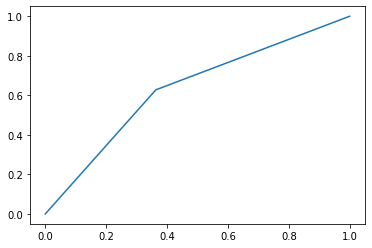

Random forest
Accuracy Score 0.7065904303340355
Confusion Matrix: 
 [[4946 1853]
 [2047 4446]]
AUC Score 0.7060986650472489


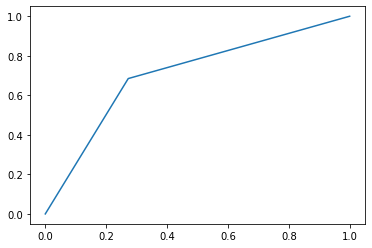

KNN
Accuracy Score 0.7071170628949744
Confusion Matrix: 
 [[5497 1302]
 [2591 3902]]
AUC Score 0.7047280623320299


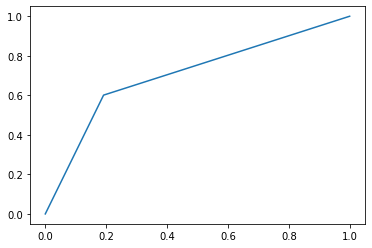

SVM
Accuracy Score 0.6093891062293109
Confusion Matrix: 
 [[4588 2211]
 [2981 3512]]
AUC Score 0.6078476539172702


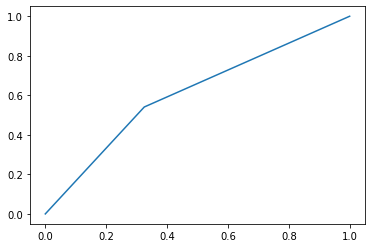

Naive bayes
Accuracy Score 0.7195305446885345
Confusion Matrix: 
 [[5587 1212]
 [2516 3977]]
AUC Score 0.7171221332025187


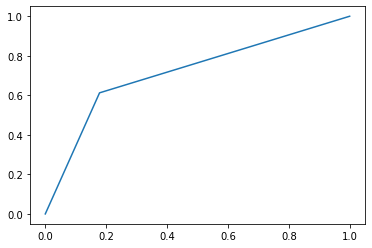

Logistic Regression
Accuracy Score 0.7294613301233824
Confusion Matrix: 
 [[5424 1375]
 [2221 4272]]
AUC Score 0.7278518481905922


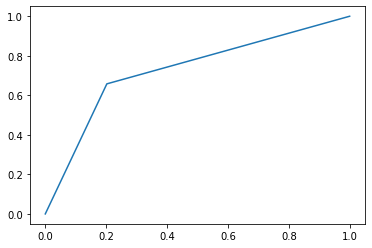

In [421]:
dec = DecisionTreeClassifier()
ran = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=100)
svm = SVC(random_state=1)
naive = GaussianNB()
logreg = lm.LogisticRegression(solver="liblinear", max_iter=200)

#models to be fitted
#later part added AUC scores and plots for better evaluation
models = {"Decision tree" : dec,
          "Random forest" : ran,
          "KNN" : knn,
          "SVM" : svm,
          "Naive bayes" : naive,
          "Logistic Regression" : logreg}
scores= { }
auc={ }

for key, value in models.items():    
    model = value
    model.fit(x_train, y_train)
    scores[key] = model.score(x_test, y_test)
    print(key)
    print("Accuracy Score", scores[key])

    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred.round())
    print("Confusion Matrix:", "\n", cm)

    tpr, fpr, threshold = roc_curve(y_test, y_pred)
    auc[key] = roc_auc_score(y_test, y_pred)
    print("AUC Score", auc[key])

    plt.plot(tpr, fpr)
    plt.show()

In [422]:
scores

{'Decision tree': 0.6323352392416491,
 'KNN': 0.7071170628949744,
 'Logistic Regression': 0.7294613301233824,
 'Naive bayes': 0.7195305446885345,
 'Random forest': 0.7065904303340355,
 'SVM': 0.6093891062293109}

In [424]:
auc

{'Decision tree': 0.6322286571210328,
 'KNN': 0.7047280623320299,
 'Logistic Regression': 0.7278518481905922,
 'Naive bayes': 0.7171221332025187,
 'Random forest': 0.7060986650472489,
 'SVM': 0.6078476539172702}

In [423]:
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 ,ascending=False, inplace=True)
scores_frame

,Accuracy Score
Logistic Regression,0.729461
Naive bayes,0.719531
KNN,0.707117
Random forest,0.706590
Decision tree,0.632335
SVM,0.609389


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

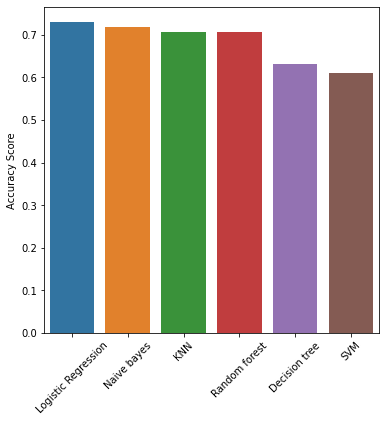

In [425]:
plt.figure(figsize=(6,6))
sns.barplot(x=scores_frame.index,y=scores_frame["Accuracy Score"])
plt.xticks(rotation=45) 
# Rotation of model names...

###Optimization Techniques : Cross Validation & Parameter Tuning

In [426]:
#K Fold Cross Validation
#With K-Fold cross-validation, we obtain "K" pieces of results from different mini-training sets from our main training set.
#Then we choose the average of these results as the actual result.
#After all, by taking the standard deviation of K result, we can examine whether the data is consistent.

accuracies_log_reg = cross_val_score(estimator=logreg, X=x_train, y=y_train, cv=10)
accuracies_random_forest = cross_val_score(estimator=ran, X=x_train, y=y_train, cv=10)
accuracies_knn = cross_val_score(estimator=knn, X=x_train, y=y_train, cv=10)


In [427]:
print("Random Forest Average accuracy: ", accuracies_random_forest.mean())
print("Random Forest Standard Deviation: ", accuracies_random_forest.std())
print("KNN Average accuracy: ", accuracies_knn.mean())
print("KNN Standard Deviation: ", accuracies_knn.std())
print("Logistic Regression Average accuracy: ", accuracies_log_reg.mean())
print("Logistic Regression Standard Deviation: ", accuracies_log_reg.std())

Random Forest Average accuracy:  0.7105537514507253
Random Forest Standard Deviation:  0.006390288738007732
KNN Average accuracy:  0.7011304512847117
KNN Standard Deviation:  0.005455356209562341
Logistic Regression Average accuracy:  0.7266725070698314
Logistic Regression Standard Deviation:  0.005558822728571465


In [428]:
#Let us use grid search algorithm, in order to find the best 
#Random Forest Algorithm's "n_estimators" hyperparameter value for our model, l
# grid search cross validation with 1 hyperparameter 

grid = {"n_estimators" : np.arange(10,150,10)}

ran_cv = GridSearchCV(ran, grid, cv=3) # GridSearchCV
ran_cv.fit(x_train,y_train)# Fit

# Print hyperparameter
print("Tuned hyperparameter n_estimators: {}".format(ran_cv.best_params_)) 
print("Best score: {}".format(ran_cv.best_score_))


Tuned hyperparameter n_estimators: {'n_estimators': 130}
Best score: 0.7107980742125957


Test accuracy:  0.7108787240445381
Confusion Matrix: 
 [[4977 1822]
 [2021 4472]]
AUC Score 0.7103805682370509


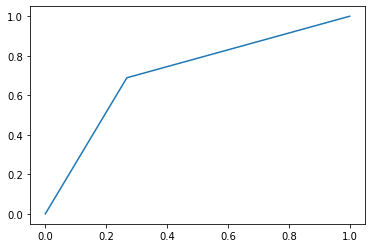

In [429]:
#Test Set Accuracy Score for Random forest¶
#Now we have selected our model with better hyper parameters than default ones.
#It is time to evaluate model with our test set
ran_best = RandomForestClassifier(n_estimators=130)
ran_best.fit(x_train, y_train)
print("Test accuracy: ",ran_best.score(x_test, y_test))

y_pred = ran_best.predict(x_test)
cm = confusion_matrix(y_test, y_pred.round())
print("Confusion Matrix:", "\n", cm)

tpr, fpr, threshold = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print("AUC Score", auc)

plt.plot(tpr, fpr)
plt.show()

In [ ]:
#log_reg = LogisticRegression(solver="liblinear", max_iter=200)
grid = {"penalty" : ["l1", "l2"],
         "C" : np.arange(60,80,2)} # (60,62,64 ... 78)
log_reg_cv = GridSearchCV(logreg, grid, cv=3)
log_reg_cv.fit(x_train, y_train)

# Print hyperparameter
print("Tuned hyperparameter n_estimators: {}".format(log_reg_cv.best_params_)) 
print("Best score: {}".format(log_reg_cv.best_score_))

In [ ]:
#Test Set Accuracy Score ¶
#Now we have selected our model with better hyper parameters than default ones.
#It is time to evaluate model with our test set
logreg_best = LogisticRegression(C=74, penalty="l1", solver="liblinear")
logreg_best.fit(x_train, y_train)
print("Test accuracy: ",logreg_best.score(x_test, y_test))

y_pred = logreg_best.predict(x_test)
cm = confusion_matrix(y_test, y_pred.round())
print("Confusion Matrix:", "\n", cm)

tpr, fpr, threshold = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print("AUC Score", auc)

plt.plot(tpr, fpr)
plt.show()

In [ ]:
# chk=logreg_best.fit(x_train, y_train)
# print(chk.summary())


In [ ]:
# Get numerical feature importances
importances = list(logreg_best.coef_[0])
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
#Plotting confusion matrix for logistic
y_true = y_test
#y_pred = logreg_best.predict(x_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm,fmt=".0f", annot=True,linewidths=0.2, linecolor="purple", ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Grand Truth")
plt.show()

In [ ]:
TN = cm[0,0]
TP = cm[1,1]
FN = cm[1,0]
FP = cm[0,1]
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
F1_Score = 2*(Recall * Precision) / (Recall + Precision)
pd.DataFrame([[Precision, Recall, F1_Score]],columns=["Precision", "Recall", "F1 Score"], index=["Results"])
#High precision relates to the low false positive rate
#High recall relates to the low false negative rate


In [ ]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")


In [ ]:
#XGBoost simple model fit

xgb_clf = XGBClassifier()
xgb_clf.fit(x_train, y_train)

print_score(xgb_clf, x_train, y_train, x_test, y_test, train=True)
print_score(xgb_clf, x_train, y_train, x_test, y_test, train=False)

y_pred = xgb_clf.predict(x_test)

tpr, fpr, threshold = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
print("AUC-score:", auc_score)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(tpr, fpr)
plt.show()

In [ ]:
#Hyper-Parameter tuning using GridSearchCV
##Round 1
# param_grid= {
#     'max_depth' : [3,4,5],
#     'learning_rate': [0.1,0.01,0.05],
#     'gamma':[0,0.25,1.0],
#     'reg_lambda': [0,1.0,10.0]
# }
#Tuned hyperparameter n_estimators: {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 10.0}
#Best score: 0.7979720547889348

##Round 2
param_grid= {
    'max_depth' : [5,6,7],
    'learning_rate': [0.1,0.5,1],
    'gamma':[0.25],
    'reg_lambda': [10.0,20,100]
}
# Tuned hyperparameter n_estimators: {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 10.0}
# Best score: 0.7979720547889348
#To speed up cross validation and to prevent overfitting we use random subset of data (90%) and of features (50%) per tree.
XGB_grid= GridSearchCV(estimator=XGBClassifier(objective='binary:logistic', 
                                               seed=42,
                                               subsample=0.9,
                                               colsample_bytree=0.5),
                       param_grid=param_grid,
                       scoring='roc_auc',
                       verbose=0,
                       n_jobs=10,
                       cv=3
                       )
best_xgb.fit(x_train, y_train)

# Print hyperparameter
print("Tuned hyperparameter n_estimators: {}".format(best_xgb.best_params_)) 
print("Best score: {}".format(best_xgb.best_score_))

In [ ]:
#Test Set Accuracy Score ¶
#Now we have selected our model with better hyper parameters than default ones.
#It is time to evaluate model with our test set
Xgb_best = XGBClassifier(seed=42 ,
                         objective='binary:logistic',
                         gamma= 0.25, 
                         learning_rate= 0.1,
                         max_depth = 5,
                         reg_lambda = 10.0,
                         subsample=0.9,
                         colsample_bytree=0.5)

Xgb_best.fit(x_train,
             y_train,
             early_stopping_rounds=10,
             eval_metric='aucpr',
             eval_set=[(x_test,y_test)])




In [ ]:
print("Test accuracy: ",Xgb_best.score(x_test, y_test))

y_pred = Xgb_best.predict(x_test)
cm = confusion_matrix(y_test, y_pred.round())
print("Confusion Matrix:", "\n", cm)

tpr, fpr, threshold = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print("AUC Score", auc)

plt.plot(tpr, fpr)
plt.show()

In [ ]:
#Plotting the confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(Xgb_best,x_test,y_test,values_format="d",display_labels=["CVD","No CVD"])

In [ ]:
#Plotting the Decision Tree
import xgboost as xgb

# bst=Xgb_best.get_booster()
# for importance_type in ("weight" , "gain", "cover", "total_gain", "total_cover"):
#   print('%s: ' % importance_type, bst.get_score(importance_type=importance_type)))
node_params={"shape" : "box",
             "style": "filled,rounded",
             "fillcolor": "#78cbe"}

leaf_params={"shape" : "box",
             "style": "filled,rounded",
             "fillcolor": "#e48038"}

xgb.to_graphviz(Xgb_best,num_trees=0,size="40,40",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

In [ ]:
# #Optimising upon lowering false negatives i.e. improving recall.
# from sklearn.model_selection import StratifiedKFold

# #The scorers dictionary can be used as the scoring argument in GridSearchCV. 
# #When multiple scores are passed, GridSearchCV.cv_results_ will return scoring metrics for each of the score types provided.
# scorers = {
#     'precision_score': make_scorer(precision_score),
#     'recall_score': make_scorer(recall_score),
#     'accuracy_score': make_scorer(accuracy_score)
# }

# #random forests have many tunable parameters, which make it suitable for GridSearchCV
# param_grid = {
#     'min_samples_split': [3, 5, 10], 
#     'n_estimators' : [100, 300],
#     'max_depth': [3, 5, 15, 25],
#     'max_features': [3, 5, 10, 20]
# }

# #The function below uses GridSearchCV to fit several classifiers according to the combinations of parameters in the param_grid. 
# #The scores from scorers are recorded and the best model (as scored by the refit argument) will be selected and "refit" to the full training data for downstream use. 
# #This also makes predictions on the held out X_test and prints the confusion matrix to show performance.
# def grid_search_wrapper(refit_score='recall_score'):
#     """
#     fits a GridSearchCV classifier using refit_score for optimization
#     prints classifier performance metrics
#     """
#     skf = StratifiedKFold(n_splits=10)
#     grid_search = GridSearchCV(ran, param_grid, scoring=scorers, refit=refit_score,
#                            cv=skf, return_train_score=True, n_jobs=-1)
#     grid_search.fit(x_train, y_train)

#     # make the predictions
#     y_pred = grid_search.predict(x_test.values)

#     print('Best params for {}'.format(refit_score))
#     print(grid_search.best_params_)

#     # confusion matrix on the test data.
#     print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
#     print(pd.DataFrame(confusion_matrix(y_test, y_pred),
#                  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
#     return grid_search

# grid_search_clf = grid_search_wrapper(refit_score='recall_score')
